# Using `redflag`

It's early days, but there are a few things you can do:

- Outlier detection
- Clipping detection
- Imbalance metrics (for labels and any other categorical variables)
- Distribution shape

In [1]:
import redflag as rf

rf.__version__

'0.1.0'

## Load some data

In [2]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Well Name      3966 non-null   object 
 1   Depth          3966 non-null   float64
 2   Formation      3966 non-null   object 
 3   RelPos         3966 non-null   float64
 4   Marine         3966 non-null   int64  
 5   GR             3966 non-null   float64
 6   ILD            3966 non-null   float64
 7   DeltaPHI       3966 non-null   float64
 8   PHIND          3966 non-null   float64
 9   PE             3966 non-null   float64
 10  Facies         3966 non-null   float64
 11  LATITUDE       3966 non-null   float64
 12  LONGITUDE      3966 non-null   float64
 13  ILD_log10      3966 non-null   float64
 14  Lithology      3966 non-null   object 
 15  RHOB           3966 non-null   float64
 16  Mineralogy     3966 non-null   object 
 17  Siliciclastic  3966 non-null   bool   
dtypes: bool(

## Outliers

Currently there is only one way to detect outliers, using the Z-score. The function transforms the features to Z-score and checks how many samples are more than 3 standard deviations away from the mean (ordinary outliers), and how many are more than 4.89 standard deviations away (extreme outliers). The ratio of actual:expected samples is returned, along with the indices of those samples.

In [4]:
rf.has_outliers(df['PHIND'])

array([49.715, 51.805, 51.3  , 50.85 , 48.464, 52.369, 48.597, 49.787,
       47.721])

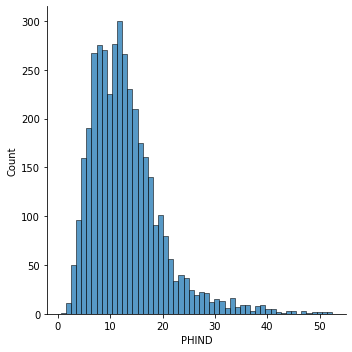

In [5]:
import seaborn as sns

sns.displot(df['PHIND'])

## Clipping

If a feature has been clipped, it will have multiple instances at its min and/or max value. There are legitimate reasons why this might happen, for example the feature may be naturally bounded (e.g. porosity is always greater than 0), or the feature may have been deliberately clipped as part of the data preparation process.

In [6]:
rf.is_clipped(df['GR'])

True

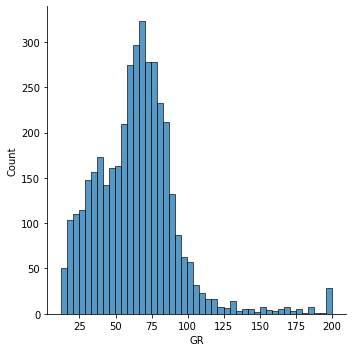

In [7]:
import seaborn as sns

sns.displot(df['GR'])

## Imbalance metrics

For binary targets, the metric is imbalace ratio (ratio between majority and minority class).

For multiclass targets, the metric is imbalance degree, a single-value measure that explains (a) how many minority classes there are and (b) how skewed the supports are.

In [8]:
rf.class_imbalance(df['Lithology'])

3.378593040847201

In [9]:
rf.minority_classes(df['Lithology'])

array(['wackestone', 'dolomite', 'mudstone', 'sandstone'], dtype=object)

In [85]:
def kullback_leibler(ζ, e):
    """
    Kulllback-Leibler divergence between discrete probability distributions.
    Note that this function is not commutative.
    Not recommended in Ortigosa-Hernandez et al. (2017).
    """
    return np.sum(ζ * np.log((ζ+1e-12) / e))

In [89]:
data = rf.generate_data([2, 81, 61, 4])
ζ, e = rf.empirical_distribution(data)
ζ, e

(array([0.01351351, 0.5472973 , 0.41216216, 0.02702703]),
 array([0.25, 0.25, 0.25, 0.25]))

In [66]:
i = rf.furthest_distribution(data)
e

array([0.25, 0.25, 0.25, 0.25])

In [88]:
kullback_leibler(ζ, e)

0.5353331620127415

In [87]:
(kullback_leibler(ζ, e) / kullback_leibler(i, e)) + 1

1.6497083245026594

## Distribution shape

Tries to guess the shape of the distribution from the following set from `scipy.stats`:

- `'norm'`
- `'cosine'`
- `'expon'`
- `'exponpow'`
- `'gamma'`
- `'gumbel_l'`
- `'gumbel_r'`
- `'powerlaw'`
- `'triang'`
- `'trapz'`
- `'uniform'`

The name is returned, along with the shape parameters (if any), location and scale.

In [10]:
rf.best_distribution(df['PHIND'])

BestDistribution(name='gumbel_r', shape=[], loc=10.040572536302586, scale=4.934329727517257)

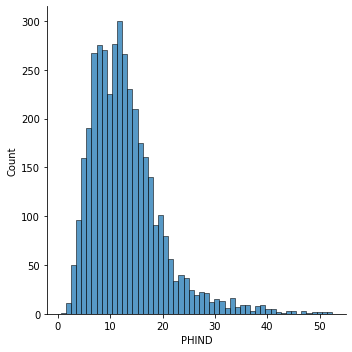

In [11]:
sns.displot(df['PHIND'])

## Self-correlation

If a feature is correlated to lagged (shifted) versions of itself, then the dataset may be ordered by that feature, or the records may not be independent. If several features are correlated to themselves, then the data instances may not be independent.

In [12]:
rf.is_correlated(df['GR'])

True

Shuffling the data removes the correlation, but does not mean the records are independent.

In [25]:
x = np.random.randint(1, 10, 10)
x

array([7, 1, 6, 8, 7, 6, 2, 9, 4, 2])

In [28]:
rf.is_correlated([1, 2, 1, 7, 6, 8, 6, 2, 1, 1])

True

In [ ]:
a = np.array()

In [13]:
import numpy as np

gr = df['GR'].to_numpy(copy=True)
np.random.shuffle(gr)
rf.is_correlated(gr)

False

---
&copy; 2022 Agile Scientific, agilescientific.com / CC BY / Apache 2.0